In [1]:

import warnings
warnings.filterwarnings("ignore")


In [2]:
!conda install -c anaconda seaborn -y
!conda install scikit-learn==0.23.0 -y
!conda install -c conda-forge imbalanced-learn==0.4.3 -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sanjayanju\Anaconda3

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.7.22  |                0         164 KB  anaconda
    certifi-2020.6.20          |           py37_0         160 KB  anaconda
    seaborn-0.10.1             |             py_0         160 KB  anaconda
    ------------------------------------------------------------
                                           Total:         484 KB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.6.2~ --> anaconda::ca-certificates-2020.7.22-0
  seaborn             anaconda/win-64::seaborn-0.9.0-py37_0 --> anaconda/noarch::seaborn-0.10.1-py_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            cond


PackagesNotFoundError: The following packages are not available from current channels:

  - scikit-learn==0.23.0

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sanjayanju\Anaconda3

  added / updated specs:
    - imbalanced-learn==0.4.3


The following packages will be UPDATED:

  conda                        anaconda::conda-4.8.4-py37_0 --> conda-forge::conda-4.8.4-py37hc8dfbb8_2

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates     anaconda::ca-certificates-2020.7.22-0 --> conda-forge::ca-certificates-2020.6.20-hecda079_0
  certifi                anaconda::certifi-2020.6.20-py37_0 --> conda-forge::certifi-2020.6.20-py37hc8dfbb8_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [ ]:
# MODIFICATIONS
import six
import sys
sys.modules['sklearn.externals.six'] = six

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# CHECK VERSIONS
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

# MODELING
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

# EVALUATION
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix


In [ ]:
# LOADING DATABASES
url='http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Accidents_2018.csv'
dataset = pd.read_csv(url,sep=",",low_memory=False)
dataset.head()

url2='http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Casualties_2018.csv'
dataset_casualties = pd.read_csv(url2,sep=",",low_memory=False)
dataset_casualties.head()

url3='http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2018.csv'
dataset_vehicles = pd.read_csv(url3,sep=",",low_memory=False)
print(dataset_vehicles.columns)

In [ ]:
# Check whether 3 databases has same number of accidents (Datasets_accidents has 122635 rows)
print(dataset.shape, dataset_casualties.groupby(['Vehicle_Reference']).count().sum(), dataset_vehicles.groupby(['Accident_Index']).count().sum())

In [ ]:
dataset_casualties1=dataset_casualties[['Accident_Index','Vehicle_Reference','Casualty_Class']]

dataset_vehicles1=dataset_vehicles[['Accident_Index','Vehicle_Reference','Vehicle_Type','Skidding_and_Overturning','1st_Point_of_Impact',
                                    'Age_Band_of_Driver','Engine_Capacity_(CC)','Age_of_Vehicle','Sex_of_Driver']]

# Renaming columns starting with number or having hyphens
dataset_vehicles1 = dataset_vehicles1.rename(columns={'1st_Point_of_Impact':'First_Point_of_Impact', 'Engine_Capacity_(CC)' : 'Engine_Capacity'})


# CHECK FOR MISSING VALUES
print(dataset_casualties1.isnull().any())
print(dataset_vehicles1.isnull().any())

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
# SIMPLIFYING AND CONDENSING DATA DATA CASUALITIES
# Creating Pedestrian involvement feature binary condition for presence of pedestrian in the accident
pedest_involv_num = [
    (dataset_casualties1['Casualty_Class'] == 3),
    (dataset_casualties1['Casualty_Class'] == 1),
    (dataset_casualties1['Casualty_Class'] == 2),
    ]

pedest_involv_labels = ['Pedestrian', 'Driver', 'Passenger']
dataset_casualties1['Pedestrian_involvement'] = np.select(pedest_involv_num, pedest_involv_labels)

# SIMPLIFYING AND CONDENSING DATA DATA VEHICLES

# Condensing some labels in the "Vehicle type" feature

#New classes:
# -1) Unknown
# 1) Pedal Cycle
# 2) Motorcycle up to 125 cc
# 3) > 125cc up to more than 500 cc
# 4) Car (any type, also rented and taxi)
dataset_vehicles1['Vehicle_Type'] = dataset_vehicles1['Vehicle_Type'].replace([-1],'Veh_type_unknown')
dataset_vehicles1['Vehicle_Type'] = dataset_vehicles1['Vehicle_Type'].replace([1],'Veh_type_Pedal_cycle')
dataset_vehicles1['Vehicle_Type'] = dataset_vehicles1['Vehicle_Type'].replace([2,3],'Veh_type_Mot_125')
dataset_vehicles1['Vehicle_Type'] = dataset_vehicles1['Vehicle_Type'].replace([4,5],'Veh_type_Mot_500')
dataset_vehicles1['Vehicle_Type'] = dataset_vehicles1['Vehicle_Type'].replace([8,9],'Veh_type_Car')
dataset_vehicles1['Vehicle_Type'] = dataset_vehicles1['Vehicle_Type'].replace([10,11,16,17,18,19,20,21,22,23,90,97,98],'Veh_type_Other')
# Condensing some labels in the "Skidding and Overturning" feature; -1 = no Skidding
dataset_vehicles1['Skidding_and_Overturning'] = dataset_vehicles1['Skidding_and_Overturning'].replace([-1,0,3,4,5],'Skidding_no')
dataset_vehicles1['Skidding_and_Overturning'] = dataset_vehicles1['Skidding_and_Overturning'].replace([1,2],'Skidding_yes')
# Preserving only information about first collision taking place on the front or back of the car
dataset_vehicles1['First_Point_of_Impact'] = dataset_vehicles1['First_Point_of_Impact'].replace([-1,0,3,4],0)

# Further narrowing of the Age band feature

# No info - dropped
# No driving license  - dropped
# Young Driver (up to 35 years old, 56% starts at 26)
# Intermediate (Driver up to 65)
# Old Driver (from 65 onward)

dataset_vehicles1['Age_Band_of_Driver'] = dataset_vehicles1['Age_Band_of_Driver'].replace([1,2,3],0)
dataset_vehicles1['Age_Band_of_Driver'] = dataset_vehicles1['Age_Band_of_Driver'].replace([4,5,6],1)
dataset_vehicles1['Age_Band_of_Driver'] = dataset_vehicles1['Age_Band_of_Driver'].replace([7,8,9],2)
dataset_vehicles1['Age_Band_of_Driver'] = dataset_vehicles1['Age_Band_of_Driver'].replace([10,11],3)
dataset_vehicles1 = pd.concat([dataset_vehicles1,pd.get_dummies(dataset_vehicles1['Age_Band_of_Driver'])], axis=1)

# Condensing Sex of Driver
dataset_vehicles1['Sex_of_Driver'] = dataset_vehicles1['Sex_of_Driver'].replace([-1,3],0)

# Creating smaller categories for Engine capacity
print(dataset_vehicles1['Engine_Capacity'].describe())

# Further narrowing of the Age band feature
ec_num = [
    (dataset_vehicles1['Engine_Capacity'] == -1),
    (dataset_vehicles1['Engine_Capacity'] > -1) & (dataset_vehicles1['Engine_Capacity'] <= 1200),
    (dataset_vehicles1['Engine_Capacity'] > 1200) & (dataset_vehicles1['Engine_Capacity'] <= 2000),
    (dataset_vehicles1['Engine_Capacity'] > 2000)
    ]

ec_labels = ['EC_unknown', 'EC_normal', 'EC_high','EC_veryhigh']
dataset_vehicles1['EC'] = np.select(ec_num, ec_labels)

# Further narrowing of the Age of vehicle feature

veh_age_num = [
    (dataset_vehicles1['Age_of_Vehicle'] == -1),
    (dataset_vehicles1['Age_of_Vehicle'] > -1) & (dataset_vehicles1['Age_of_Vehicle'] <11),
    (dataset_vehicles1['Age_of_Vehicle'] > 10) & (dataset_vehicles1['Age_of_Vehicle'] <21),
    (dataset_vehicles1['Age_of_Vehicle'] >= 20)
    ]

veh_age_labels = ['Age_veh_unknown', 'Age_veh_new', 'Age_veh_middle','Age_veh_old']
dataset_vehicles1['Age_veh'] = np.select(veh_age_num, veh_age_labels)

In [ ]:
# CREATING DUMMY VARIABLES FOR CATEGORICAL ONES (DATA CASUALTIES)
dataset_casualties1 = pd.concat([dataset_casualties1,pd.get_dummies(dataset_casualties1['Pedestrian_involvement'])], axis=1)
dataset_casualties1.drop(['Vehicle_Reference','Casualty_Class','Pedestrian_involvement','Passenger'], axis = 1,inplace=True)

# BULDING GENERAL FEATURES TABLE FOR DATA CASUALTIES
Feature1=dataset_casualties1.groupby(['Accident_Index'])['Pedestrian'].sum()
print(Feature1.head())
#
Feature2=dataset_vehicles1['Accident_Index']
Feature2 = pd.concat([Feature2,pd.get_dummies(dataset_vehicles1['Vehicle_Type'])], axis=1)
Feature2 = pd.concat([Feature2,pd.get_dummies(dataset_vehicles1['Skidding_and_Overturning'])], axis=1)
Feature2 = pd.concat([Feature2,pd.get_dummies(dataset_vehicles1['First_Point_of_Impact'])], axis=1)
Feature2.rename(columns={0 : 'First_imp_other', 1 : 'First_imp_front', 2 : 'First_imp_back'},inplace=True)
Feature2 = pd.concat([Feature2,pd.get_dummies(dataset_vehicles1['Age_Band_of_Driver'])], axis=1)
Feature2.rename(columns={-1 : 'Age_band_driver_un', 0 : 'Age_band_driver_noDL', 1 : 'Age_band_driver_young', 2 : 'Age_band_driver_intermediate', 3 : 'Age_band_driver_old'},inplace=True)
Feature2 = pd.concat([Feature2,pd.get_dummies(dataset_vehicles1['EC'])], axis=1)
Feature2 = pd.concat([Feature2,pd.get_dummies(dataset_vehicles1['Age_veh'])], axis=1)
Feature2 = pd.concat([Feature2,pd.get_dummies(dataset_vehicles1['Sex_of_Driver'])], axis=1)
Feature2.rename(columns={0 : 'Sex_driver_un', 1 : 'Sex_driver_M', 2 : 'Sex_driver_F'},inplace=True)

Feature2.drop(['Veh_type_unknown','Veh_type_Other','Skidding_no','First_imp_other','Age_band_driver_un','EC_unknown','EC_normal', 'EC_high', 'Age_veh_unknown','Sex_driver_un','Sex_driver_F'], axis = 1,inplace=True)

print(Feature2.head())
# BULDING GENERAL FEATURES TABLE FOR DATA VEHICLES
Feature2=Feature2.groupby(['Accident_Index'])['Veh_type_Car', 'Veh_type_Mot_125',
       'Veh_type_Mot_500', 'Veh_type_Pedal_cycle', 'Skidding_yes',
       'First_imp_front', 'First_imp_back', 'Age_band_driver_noDL',
       'Age_band_driver_young', 'Age_band_driver_intermediate',
       'Age_band_driver_old','EC_veryhigh', 'Age_veh_middle', 'Age_veh_new', 'Age_veh_old','Sex_driver_M'].sum()

In [ ]:
# Selecting Features from Dataset_Accidents
dataset_accidents=dataset[['Accident_Index','Accident_Severity','Number_of_Vehicles','Number_of_Casualties','Speed_limit','Junction_Detail','Light_Conditions','Weather_Conditions','Urban_or_Rural_Area']]
# Checking missing values
print(dataset_accidents.isnull().any())

# JOINING TWO DATASETS

Feature2.reset_index(inplace=True)

In [ ]:
# Condensing Vehicle number

# 1 = one vehicle
# 2 = two or more vehicles

veh_num = [
    (dataset_accidents['Number_of_Vehicles'] == 1),
    (dataset_accidents['Number_of_Vehicles'] > 1)
    ]
veh_labels = ['One_Vehic','Two_or_more_Vehic']
dataset_accidents['Num_Vehicles_Cat'] = np.select(veh_num, veh_labels)

dataset_accidents.drop(['Number_of_Vehicles'], axis = 1,inplace=True)

# Distribution of vehicles number after categorialization
g_vehicat = sns.FacetGrid(dataset_accidents, col="Accident_Severity",hue="Num_Vehicles_Cat",sharey=False)
g_vehicat.map(plt.hist,'Num_Vehicles_Cat',bins=1,log=False,color ='skyblue', ec='skyblue')

for ax in g_vehicat.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()
g_vehicat.savefig('vehic_num_cond.pdf', bbox_inches='tight')

# Condensing casualties in car accidents (new name: "Casualties_Level")

# Very unbalanced, preferred three main categories here
# Level 1 = 1 casualty
# Level 2 = 2 or more casualties
# Level 3 = more than 2 casualties

cas_num = [
    (dataset_accidents['Number_of_Casualties'] == 1),
    (dataset_accidents['Number_of_Casualties'] > 1)
    ]

# create a list of the values we want to assign for each condition
cas_labels = ['One_Casualt', 'Two_or_more_Casualt']
# create a new column and use np.select to assign values to it using our lists as arguments
dataset_accidents['Casualties_Level'] = np.select(cas_num, cas_labels)

# Inspect the distribution 
print (pd.crosstab([dataset_accidents.Accident_Severity], dataset_accidents.Casualties_Level,normalize='index'))

g_casual = sns.FacetGrid(dataset_accidents, col="Accident_Severity",hue="Casualties_Level",sharey=False)
g_casual.map(plt.hist,'Casualties_Level',bins=1,log=False,color = "skyblue", ec="skyblue")

for ax in g_casual.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g_casual.savefig('casualty_num.pdf', bbox_inches='tight')

# Condensing casualties in car accidents (new name: "Speed Limit")

speed_lim = [
    (dataset_accidents['Speed_limit'] <=40),
    (dataset_accidents['Speed_limit'] >40)
    ]

# create a list of the values we want to assign for each condition
speed_lim_labels = ['Slower_40', 'Faster_40']

# create a new column and use np.select to assign values to it using our lists as arguments
dataset_accidents['Speed_limit_threshold'] = np.select(speed_lim, speed_lim_labels)

# Inspect the distribution 
print (pd.crosstab([dataset_accidents.Accident_Severity], dataset_accidents.Speed_limit_threshold,normalize='index'))
g_speedlim = sns.FacetGrid(dataset_accidents, col="Accident_Severity",hue="Speed_limit_threshold",sharey=False)
g_speedlim.map(plt.hist,'Speed_limit_threshold',bins=1,log=False,color = "skyblue", ec="skyblue")
g_speedlim.savefig('speedlim.pdf', bbox_inches='tight')

dataset_accidents.drop(['Speed_limit'], axis = 1,inplace=True)


# Inspection of Junction Detail

print(pd.crosstab([dataset_accidents.Accident_Severity], dataset_accidents.Junction_Detail,normalize='index'))

dataset_accidents.groupby(['Junction_Detail','Accident_Severity']).size().groupby(level=1).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('junction_type.pdf', bbox_inches='tight')
plt.show()

# Renaming labels

dataset_accidents['Junction_Detail'] = dataset_accidents['Junction_Detail'].replace([-1,1,2,3,5,7,8,9],'Junct_det_other')
dataset_accidents['Junction_Detail'] = dataset_accidents['Junction_Detail'].replace([0],'Junct_det_nojunct')
dataset_accidents['Junction_Detail'] = dataset_accidents['Junction_Detail'].replace([6],'Junct_det_Tjunct')

#%% Inspection of Light Conditions

# Inspection table
print (pd.crosstab([dataset_accidents.Accident_Severity], dataset_accidents.Light_Conditions,normalize='index'))

# Inspection barplot
dataset_accidents.groupby(['Light_Conditions','Accident_Severity']).size().groupby(level=1).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('light_cond.pdf', bbox_inches='tight')
plt.show()

# Renaming labels

dataset_accidents['Light_Conditions'] = dataset_accidents['Light_Conditions'].replace([6],'Light_cond_darknolight')
dataset_accidents['Light_Conditions'] = dataset_accidents['Light_Conditions'].replace([1,4,5,7],'Light_cond_other')


#%% Inspecting Urba Rural area

dataset_accidents.groupby(['Urban_or_Rural_Area','Accident_Severity']).size().groupby(level=1).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=False)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('urban_rural.pdf', bbox_inches='tight')
plt.show()


dataset_accidents['Urban_or_Rural_Area'] = dataset_accidents['Urban_or_Rural_Area'].replace([1],'Urb_rur_Urban')
dataset_accidents['Urban_or_Rural_Area'] = dataset_accidents['Urban_or_Rural_Area'].replace([2],'Urb_rur_Rural')
dataset_accidents['Urban_or_Rural_Area'] = dataset_accidents['Urban_or_Rural_Area'].replace([-1,3],'Urb_rur_Unallocated')

#%% Inspecting weather conditions

print (pd.crosstab([dataset_accidents.Accident_Severity], dataset_accidents.Weather_Conditions,normalize='index'))

dataset_accidents.groupby(['Weather_Conditions','Accident_Severity']).size().groupby(level=1).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

In [ ]:
# ONE HOT ENCODING FOR FEATURES OF ACCIDENTS DATASET

Feature=dataset_accidents[['Accident_Index','Accident_Severity']]
Feature = pd.concat([Feature,pd.get_dummies(dataset_accidents['Num_Vehicles_Cat'])], axis=1)
Feature.drop(['One_Vehic'], axis = 1,inplace=True)
Feature = pd.concat([Feature,pd.get_dummies(dataset_accidents['Casualties_Level'])], axis=1)
Feature.drop(['One_Casualt'], axis = 1,inplace=True)
Feature = pd.concat([Feature,pd.get_dummies(dataset_accidents['Speed_limit_threshold'])], axis=1)
Feature.drop(['Slower_40'], axis = 1,inplace=True)
Feature = pd.concat([Feature,pd.get_dummies(dataset_accidents['Junction_Detail'])], axis=1)
Feature.drop(['Junct_det_other'], axis = 1,inplace=True)
Feature = pd.concat([Feature,pd.get_dummies(dataset_accidents['Light_Conditions'])], axis=1)
Feature.drop(['Light_cond_other'], axis = 1,inplace=True)
Feature = pd.concat([Feature,pd.get_dummies(dataset_accidents['Urban_or_Rural_Area'])], axis=1)
Feature.drop(['Urb_rur_Unallocated','Urb_rur_Urban'], axis = 1,inplace=True)

In [ ]:

# JOINING THE LAST DATASET
Feature.reset_index(inplace=True)
Feature=Feature.merge(Feature2, on=['Accident_Index'], how='left')
Feature=Feature.merge(Feature1, on=['Accident_Index'], how='left')
Feature.set_index('Accident_Index',inplace=True)
Feature.drop(['index'], axis = 1,inplace=True)
# BINARY CONVERSION OF MULTICLASS FEATURES
Feature_bin=Feature
Feature_bin.loc[Feature_bin.Veh_type_Car > 0, 'Veh_type_Car'] = 1
Feature_bin.loc[Feature_bin.Veh_type_Mot_125 > 0, 'Veh_type_Mot_125'] = 1
Feature_bin.loc[Feature_bin.Veh_type_Mot_500 > 0, 'Veh_type_Mot_500'] = 1
Feature_bin.loc[Feature_bin.Veh_type_Pedal_cycle > 0, 'Veh_type_Pedal_cycle'] = 1
Feature_bin.loc[Feature_bin.Skidding_yes > 0, 'Skidding_yes'] = 1
Feature_bin.loc[Feature_bin.First_imp_front > 0, 'First_imp_front'] = 1
Feature_bin.loc[Feature_bin.First_imp_back > 0, 'First_imp_back'] = 1
Feature_bin.loc[Feature_bin.Age_band_driver_noDL > 0, 'Age_band_driver_noDL'] = 1
Feature_bin.loc[Feature_bin.Age_band_driver_young > 0, 'Age_band_driver_young'] = 1
Feature_bin.loc[Feature_bin.Age_band_driver_intermediate > 0, 'Age_band_driver_intermediate'] = 1
Feature_bin.loc[Feature_bin.Age_band_driver_old > 0, 'Age_band_driver_old'] = 1
Feature_bin.loc[Feature_bin.EC_veryhigh > 0, 'EC_veryhigh'] = 1
Feature_bin.loc[Feature_bin.Age_veh_middle > 0, 'Age_veh_middle'] = 1
Feature_bin.loc[Feature_bin.Age_veh_new > 0, 'Age_veh_new'] = 1
Feature_bin.loc[Feature_bin.Age_veh_old > 0, 'Age_veh_old'] = 1
Feature_bin.loc[Feature_bin.Pedestrian > 0, 'Pedestrian'] = 1
Feature_bin.loc[Feature_bin.Sex_driver_M > 0, 'Sex_driver_M'] = 1

In [ ]:
# Inspection of Age band of Driver, Age vehicle new and Sex od Driver
g_age_driver = sns.FacetGrid(Feature, col="Accident_Severity",hue="Age_band_driver_old",sharey=False)
g_age_driver.map(plt.hist,'Age_band_driver_old',bins=1,log=True,color = "skyblue", ec="skyblue")
plt.show()
g_age_driver.savefig('ageband.pdf', bbox_inches='tight')

print(pd.crosstab([Feature.Accident_Severity], Feature.Age_band_driver_old,normalize='index'))

Feature.groupby(['Age_band_driver_old','Accident_Severity']).size().groupby(level=1).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()
print(pd.crosstab([Feature.Accident_Severity], Feature.Age_band_driver_old,normalize='index'))

Feature.groupby(['Age_veh_new','Accident_Severity']).size().groupby(level=1).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

print(pd.crosstab([Feature.Accident_Severity], Feature.Sex_driver_M,normalize='index'))

Feature.groupby(['Sex_driver_M','Accident_Severity']).size().groupby(level=1).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [15]:
# DEFINING TARGET VALUE
Y=Feature['Accident_Severity']
target='Accident_Severity'
numerical_features_columns=list(Feature._get_numeric_data().columns)
X1=Feature[['Two_or_more_Vehic','Two_or_more_Casualt','Faster_40','Junct_det_Tjunct','Junct_det_nojunct','Light_cond_darknolight','Urb_rur_Rural','Veh_type_Car','Veh_type_Pedal_cycle','Veh_type_Mot_500','Skidding_yes','First_imp_back','Age_band_driver_old','Pedestrian','EC_veryhigh','Age_veh_old']]

# X1 BUT WITH REDUCED FEATURES (accordingly to feature reduction output, see in the other sections)
X2=Feature_bin[['Two_or_more_Casualt', 'Faster_40', 'Junct_det_nojunct',
       'Light_cond_darknolight', 'Urb_rur_Rural', 'Veh_type_Car',
       'Veh_type_Pedal_cycle', 'Veh_type_Mot_500', 'Skidding_yes',
       'First_imp_back', 'Age_band_driver_old', 'Pedestrian', 'EC_veryhigh']]

# CALCULATING RELATIVE PROPORTION OF SEVERITY LEVELS
print(Feature['Accident_Severity'].value_counts())
tot=Feature['Accident_Severity'].value_counts().sum()
print(Feature['Accident_Severity'].value_counts()/tot*100)

3    97799
2    23165
1     1671
Name: Accident_Severity, dtype: int64
3    79.748033
2    18.889387
1     1.362580
Name: Accident_Severity, dtype: float64


Counter({3: 97799, 2: 23165, 1: 1671})
Counter({3: 13000, 1: 9000, 2: 9000})


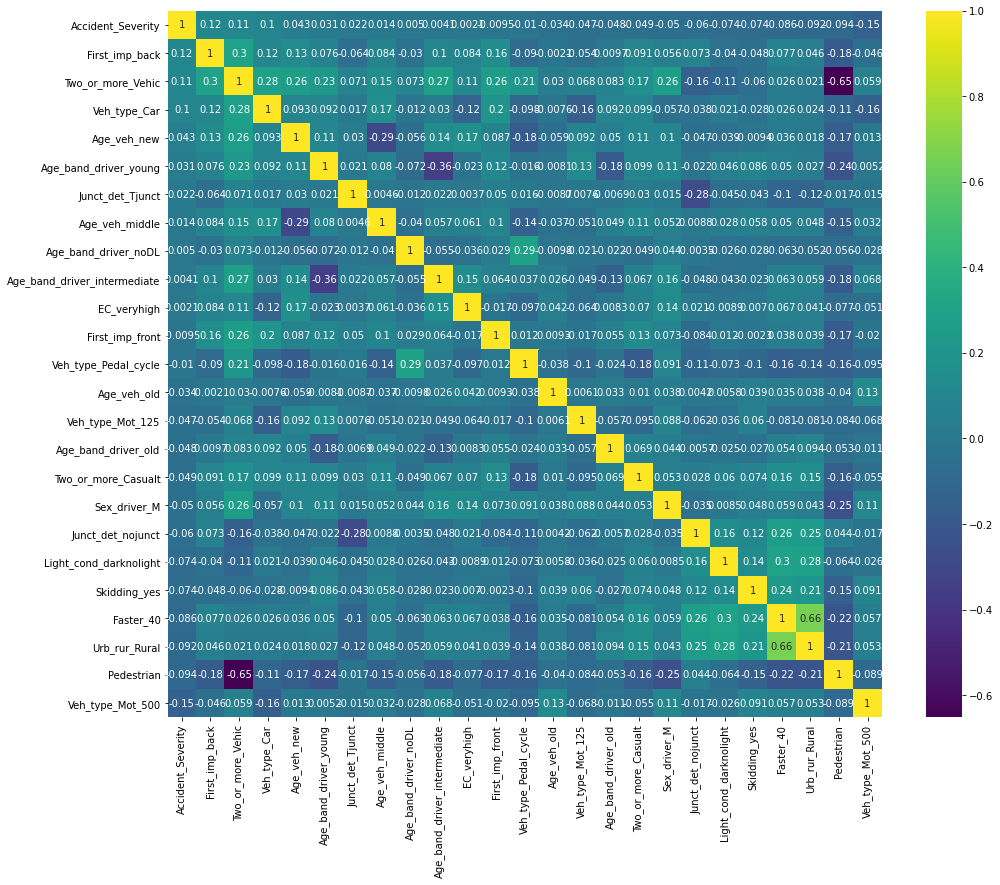

In [16]:
#%% BALANCING DATASET
# Oversampling the minor class up to 10% of the major one and downsampling the other to this value (more or less)

from collections import Counter

import six
import sys
sys.modules['sklearn.externals.six'] = six

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

counter = Counter(Y)
print(counter)

dicct={1: 9000, 2: 23165, 3: 97799}
dicct2={1: 9000, 2: 9000, 3: 13000}

over = SMOTE(sampling_strategy=dicct)
under = RandomUnderSampler(sampling_strategy=dicct2)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# Transforming dataset
X_new1, Y_new1 = pipeline.fit_resample(X1, Y)
counter = Counter(Y_new1)
print(counter)

# CORRELATION ANALYSIS
kcorr=25
cols_corr=Feature[numerical_features_columns].corr().nlargest(kcorr,target)[target].index
cm=Feature[cols_corr].corr()
fig1=plt.figure(figsize=(16,13))
sns.heatmap(cm, annot=True, cmap='viridis')


In [ ]:

# SPLITTING DATASET INTO TRAINING AND TEST DATASET
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_new1, Y_new1, test_size=0.2, random_state=0,stratify=Y_new1)

#%% STANDARDIZING DATASETS
X_train1 = preprocessing.StandardScaler().fit(X_train1).transform(X_train1.astype(float))
X_test1 = preprocessing.StandardScaler().fit(X_test1).transform(X_test1.astype(float))

In [ ]:
## THIS CELL IS VERY LONG TO COMPILE, SKIP IT
# RECURSING FEATURE ELIMINATION + CROSS VALIDATION
log_reg_model=LogisticRegression(solver='saga',max_iter = 4000,multi_class='multinomial',class_weight='balanced')

from sklearn.feature_selection import RFECV

rfecv=RFECV(estimator=log_reg_model, step=1, cv=5, scoring='accuracy')
rfecv=rfecv.fit(X_train1,Y_train1)
print('No of features to keep:', rfecv.n_features_)
print('Keep following features:', X1.columns[rfecv.support_])

print(rfecv.grid_scores_)

fig_rfe=plt.figure()
plt.xlabel("Number of features")
plt.ylabel("Cross validation score")
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_)

In [ ]:
#%% X1 BUT WITH REDUCED FEATURES
X2=Feature_bin[['Two_or_more_Casualt', 'Faster_40', 'Junct_det_nojunct',
       'Light_cond_darknolight', 'Urb_rur_Rural', 'Veh_type_Car',
       'Veh_type_Pedal_cycle', 'Veh_type_Mot_500', 'Skidding_yes',
       'First_imp_back', 'Age_band_driver_old', 'Pedestrian', 'EC_veryhigh']]

In [ ]:

#%% CALCULATING RELATIVE PROPORTION OF SEVERITY LEVELS

print(Feature['Accident_Severity'].value_counts())
tot=Feature['Accident_Severity'].value_counts().sum()
print(Feature['Accident_Severity'].value_counts()/tot*100)

In [ ]:
#%% CREATING NEW DATAFRAME WITH FEATURES REDUCTION APPLIED
counter = Counter(Y)
print(counter)

dicct={1: 9000, 2: 23165, 3: 97799}
dicct2={1: 9000, 2: 9000, 3: 13000}

over = SMOTE(sampling_strategy=dicct)
under = RandomUnderSampler(sampling_strategy=dicct2)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# Transforming dataset
X_new, Y_new = pipeline.fit_resample(X2, Y)
counter = Counter(Y_new)
print(counter)

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=0,stratify=Y_new)
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

In [ ]:

## THIS CELL IS VERY LONG TO COMPILE, SKIP IT
# LOGISTIC REGRESSION
# Optimizing hyperparameters

from sklearn.linear_model import LogisticRegression

parameters1 = {'solver':['newton-cg','lbfgs','sag','saga'],
     'C': [0.001,0.01,0.1,0.5,1,10,100]}

Inspection_reglog = GridSearchCV(LogisticRegression(max_iter = 4000,multi_class='auto',class_weight='balanced'), 
                                 param_grid=parameters1,refit=True,cv=5)
Inspection_reglog.fit(X_train, Y_train)

print ("Best accuracy: {}".format(Inspection_reglog.best_score_))
print ("Parameters to use: {}".format(Inspection_reglog.best_params_))

In [ ]:
# LOGISTIC REGRESSION
# Running model with hyperparameters optimized
logreg_model= LogisticRegression(C=10, solver='sag',max_iter = 4000,multi_class='multinomial',class_weight='balanced').fit(X_train,Y_train)

yhat_logreg = logreg_model.predict(X_test)
yhat_prob = logreg_model.predict_proba(X_test)
# Other validation methods
logreg_jaccard=jaccard_score(Y_test, yhat_logreg,average='weighted')
logreg_f1=f1_score(Y_test, yhat_logreg, average='weighted')
logreg_logloss=log_loss(Y_test, yhat_prob)

print ('LOG_REG Jaccard:', logreg_jaccard)
print ('LOG_REG f1:', logreg_f1)
print ('LOG_REG log loss:', logreg_logloss)

labels_cm=['Fatal','Severe','Slight']
# Plot onfusion matrix
disp = plot_confusion_matrix(logreg_model, X_test, Y_test,display_labels=labels_cm,cmap=plt.cm.Blues,normalize='true')
disp.ax_.set_title("Confusion matrix Logistic Regression")
print(disp.confusion_matrix)
plt.show()

In [ ]:
## THIS CELL IS VERY LONG TO COMPILE, SKIP IT
# KNN Model

from sklearn.neighbors import KNeighborsClassifier

ks = 40 # Maximal value for k
mean_acc = np.zeros((ks-1))
error = []

for n in range(1,ks):
    #Train Model with 10 increments of k to find best accuracy 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,Y_train)
    yhat_knn1=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(Y_test, yhat_knn1)
    error.append(np.mean(yhat_knn1 != Y_test))

best_k=pd.Series(mean_acc).idxmax()+1

print('The k giving the highest accuracy individuated is: ',best_k)
print('Accuracy of KNN model on splitted training data: ',mean_acc[best_k-1])

In [ ]:
#%% Plot mean error predicted by KNN model - confirms GridSearch
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='black', linestyle='solid', marker='o',
         markerfacecolor='skyblue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.vlines(26, min(error), max(error), colors='red', linestyles='dashed')
plt.savefig('meanerrorknn.pdf', bbox_inches='tight')

In [ ]:
# Building the model again, using k=13
from sklearn.neighbors import KNeighborsClassifier
k = 26
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,Y_train)

knn_yhat = kNN_model.predict(X_test)
knn_yhat_prob = kNN_model.predict_proba(X_test)

knn_jaccard=jaccard_score(Y_test, knn_yhat,average='weighted')
knn_f1=f1_score(Y_test, knn_yhat, average='weighted')
knn_logloss=knn_logloss=log_loss(Y_test, knn_yhat_prob)

print ('KNN Jaccard index:', knn_jaccard)
print ('KNN f1:', knn_f1)
print ('KNN log loss:', knn_logloss)
#%%Error rate


labels_cm=['Fatal','Severe','Slight']
# Plotting confusion matrix for KNN
disp = plot_confusion_matrix(kNN_model, X_test, Y_test,display_labels=labels_cm,cmap=plt.cm.Blues,normalize='true')
disp.ax_.set_title("Confusion matrix KNN")
print(disp.confusion_matrix)
plt.show()

In [ ]:
# DECISION TREE MODEL
## THIS CELL IS VERY LONG TO COMPILE, SKIP IT
parameters_dt = {'max_depth': [2,5,10],'criterion':['gini','entropy'],
     'min_samples_leaf': [2,5,10,20],"min_samples_split": [2, 10, 20],"max_leaf_nodes": [5, 10, 20]}
# 10 fold cross validation applied three times, total 30 models run
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

Inspection_dt = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid=parameters_dt, cv=cv)
Inspection_dt.fit(X_train, Y_train)

print ("Best accuracy: {}".format(Inspection_dt.best_score_))
print ("Parameters to use: {}".format(Inspection_dt.best_params_))

In [ ]:
# Run the DecisionTree model with the best parameters individuated
accid_tree = DecisionTreeClassifier(criterion="entropy",max_depth = 10, min_samples_leaf = 20,class_weight='balanced',max_leaf_nodes=20,min_samples_split=2)
accid_tree.fit(X_train, Y_train)

# Predicting test values accordingly to DecisionTree model previously defined
yhat_tree=accid_tree.predict(X_test)
tree_yhat_prob = accid_tree.predict_proba(X_test)

# Calculating accuracy
tree_jaccard=jaccard_score(Y_test, yhat_tree,average='weighted')
tree_f1=f1_score(Y_test, yhat_tree, average='weighted')
tree_logloss=log_loss(Y_test, tree_yhat_prob)

print ('Decision Tree Jaccard index:', tree_jaccard)
print ('Decision Tree f1:', tree_f1)
print ('Decision Tree log loss:', tree_logloss)

# plotting confusion matrix
labels_cm=['Fatal','Severe','Slight']
disp = plot_confusion_matrix(accid_tree, X_test, Y_test,display_labels=labels_cm,cmap=plt.cm.Blues,normalize='true')
disp.ax_.set_title("Confusion matrix decision tree")
print(disp.confusion_matrix)
plt.show()

In [ ]:
from sklearn import tree
class_names=['1','2','3']
feat_names=['Two_or_more_Casualt', 'Faster_40', 'Junct_det_nojunct',
       'Light_cond_darknolight', 'Urb_rur_Rural', 'Veh_type_Car',
       'Veh_type_Pedal_cycle', 'Veh_type_Mot_500', 'Skidding_yes',
       'First_imp_back', 'Age_band_driver_old', 'Pedestrian', 'EC_veryhigh']

fig = plt.figure(figsize=(50,45))
_ = tree.plot_tree(accid_tree, 
                   feature_names=feat_names,  
                   class_names=class_names,
                   filled=True)
plt.show()

In [ ]:
# REGULAR BOOSTING CLASSIFIER
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

#scaler = MinMaxScaler()

#lr_list = [0.01, .05, 0.075, 0.1, 0.25, 0.5, 0.75, 1] # different learning rates
lr_list = [0.01, 0.25, .05, 0.075, 0.1] # different learning rates lowering from 0.1

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=9, max_depth=5, random_state=0)
    gb_clf.fit(X_train, Y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, Y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, Y_test)))

In [ ]:

# Running REGULAR BOOSTING CLASSIFIER model with hyperparameters optimized
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=9, max_depth=5, random_state=0)
gb_clf2.fit(X_train, Y_train)
yhat_boost = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(Y_test, yhat_boost))

print("Classification Report")
print(classification_report(Y_test, yhat_boost))

# Calculating accuracy
boost_jaccard=jaccard_score(Y_test, yhat_boost,average='weighted')
boost_f1=f1_score(Y_test, yhat_boost, average='weighted')
boost_logloss=log_loss(Y_test, tree_yhat_prob)

print ('Decision Tree Jaccard index:', tree_jaccard)
print ('Decision Tree f1:', tree_f1)
print ('Decision Tree log loss:', tree_logloss)

# PLOTTING CONFUSION MATRIX 
labels_cm=['Fatal','Severe','Slight']

dispcm = plot_confusion_matrix(gb_clf, X_test, Y_test,display_labels=labels_cm,cmap=plt.cm.Blues,normalize='true')
dispcm.ax_.set_title("Confusion matrix Gradient Boosting Classifier")
print(dispcm.confusion_matrix)
plt.savefig('gradboostcm.pdf', bbox_inches='tight')
plt.show()

[0.05291515 0.07809208 0.05924406 0.02521736 0.05112475 0.03630767
 0.05689801 0.05984992 0.06144316 0.16576716 0.05146636 0.09291976
 0.04865775 0.08165683 0.04867211 0.02976786]
Index(['Two_or_more_Vehic', 'Two_or_more_Casualt', 'Faster_40',
       'Junct_det_Tjunct', 'Junct_det_nojunct', 'Light_cond_darknolight',
       'Urb_rur_Rural', 'Veh_type_Car', 'Veh_type_Pedal_cycle',
       'Veh_type_Mot_500', 'Skidding_yes', 'First_imp_back',
       'Age_band_driver_old', 'Pedestrian', 'EC_veryhigh', 'Age_veh_old'],
      dtype='object')
                  features     score
0         Veh_type_Mot_500  0.165767
1           First_imp_back  0.092920
2               Pedestrian  0.081657
3      Two_or_more_Casualt  0.078092
4     Veh_type_Pedal_cycle  0.061443
5             Veh_type_Car  0.059850
6                Faster_40  0.059244
7            Urb_rur_Rural  0.056898
8        Two_or_more_Vehic  0.052915
9             Skidding_yes  0.051466
10       Junct_det_nojunct  0.051125
11             E

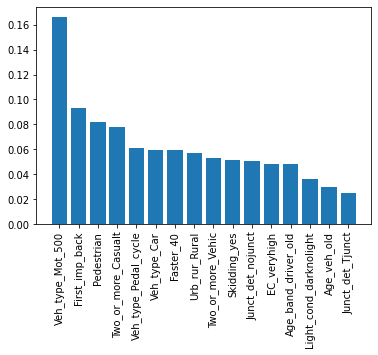

In [17]:
# FEATURE IMPORTANCE USING TREE CLASSIFIER (10 TREES)

from sklearn.ensemble import ExtraTreesClassifier
# load data

# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X1, Y)
print(model.feature_importances_)
print(X1.columns)

importance=pd.DataFrame(model.feature_importances_,X1.columns)
importance.rename(columns={0 : 'score'},inplace=True)
importance.sort_values(by='score',ascending=False,inplace=True)
importance.reset_index(inplace=True)
importance.columns = ['features','score']
plt.bar(importance.features,importance.score)
plt.xticks(rotation=90)
plt.savefig('importance.pdf', bbox_inches='tight')
print(importance)